## Remixing FaffyWaffle55's 2020 tracker

I want to see what is the most likely activity after each activity

In [1]:
import pandas as pd
# for better viewing
pd.set_option("display.max_columns", 40)

In [2]:
data_url = "https://drive.google.com/file/d/1so2Lz09MjKqb1jiRvREvnoyD2BM9Kllf/view?usp=sharing"

First we'll download the data from the shared sheet.

We'll need to "melt" the data down so that each row is one 15-minute interval

We'll also need the "Key" sheet so that we can put names to the activities.

In [3]:
read_df = pd.read_excel("Time management shared.xlsx", sheet_name=0)

<ipython-input-3-100df2736734>:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  read_df = pd.read_excel("Time management shared.xlsx", sheet_name=0)


In [4]:
key = pd.read_excel("Time management shared.xlsx", sheet_name="Key", index_col=0)

<ipython-input-4-7cd29ba4978a>:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  key = pd.read_excel("Time management shared.xlsx", sheet_name="Key", index_col=0)


In [5]:
## clean up functions
def ffill_month_week(df):
    df["Month"] = df.Month.ffill()
    df["Week"] = df.Week.ffill()
    return df

def drop_nas(df):
    "drops columns first"
    df = df.iloc[:,:-3]
    df = df.dropna(axis=0)
    return df

def melt_data(df):
    df = df.melt(id_vars=["Month","Week","Date","Day"],var_name="interval",value_name="activity")
    df["interval_dt"] = pd.to_datetime(df.Date.astype(str) + " " + df.interval.astype(str))
    df = df.sort_values('interval_dt')
    return df

In [6]:
## find next activity
def next_activity(row):
    """finds the code for the next activity, requires a sorted df"""
    idx = row.name
    try:
        next_row = df.iloc[idx+1]
        next_activity = next_row.activity
    except:
        next_activity = None
    return next_activity

In [7]:
df = read_df.pipe(ffill_month_week).pipe(drop_nas).pipe(melt_data)

In [8]:
# apply the next activity function
df["next_activity"] = df.apply(next_activity, axis=1)

In [9]:
# bring in the names
df["activity_name"] = df.activity.map(key.Key)
df["next_activity_name"] = df.next_activity.map(key.Key)

In [10]:
# here we see if it's the same activity, so that we can filter out blocks
# of same activity
df["is_same_activity"] = df.activity_name == df.next_activity_name

In [11]:
pivot = df[~df.is_same_activity].groupby(["activity_name","next_activity_name"]).next_activity.count().unstack().fillna(0)
pivot.style.background_gradient(cmap="Greens").set_precision(0)

next_activity_name,Administration,"Basic Admin - Cleaning, Packing Bags Etc",Bus,CFA Exam,Career / Networking / Work,Downtime/Relax,Driving,Eating and Drinking,Emails,Flying,Friends and Family,Gym,Hygiene - General,Hygiene – Getting Changed,Hygiene – wind down,Low Intensity,Medium & High Intensity,Organisation,Other sport activities,Reading,Recreational Activity,Rest,Shopping,Sleep,Social Media,Spreadsheet,Subject 1,Subject 2,Subject 3,Subject 4,Subject 5,Subject 6,Train,Transit,Waiting,Walking,Work 2 - Maintenance or Labour
activity_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Administration,0,5,2,0,25,1,14,39,0,0,37,0,1,5,12,0,1,0,0,0,0,0,1,157,71,2,6,4,4,16,15,25,1,0,0,4,3
"Basic Admin - Cleaning, Packing Bags Etc",7,0,0,0,19,1,16,24,0,0,29,1,2,10,13,0,2,0,0,0,0,0,1,152,61,2,7,6,10,14,10,15,0,0,0,3,3
Bus,4,0,0,0,5,0,0,7,0,0,2,0,0,0,2,0,0,0,0,0,0,0,0,21,9,0,1,3,1,4,3,1,0,0,0,0,0
CFA Exam,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4,2,1,0,1,0,0,1,0,1,0,0,0,0
Career / Networking / Work,43,44,4,0,0,3,89,279,2,1,215,6,8,30,74,1,13,1,9,5,11,1,14,1178,447,50,34,40,52,71,101,110,14,0,1,47,47
Downtime/Relax,0,0,0,0,3,0,0,2,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,6,4,0,0,0,0,0,1,0,0,0,0,0,1
Driving,19,6,1,0,57,0,0,64,0,0,47,1,1,11,17,0,1,0,0,0,3,1,4,277,152,5,12,23,17,19,25,53,1,0,0,10,6
Eating and Drinking,39,25,0,1,145,2,48,0,0,1,167,1,2,22,49,0,6,0,1,7,11,13,4,979,425,24,28,26,25,196,73,169,3,1,2,40,15
Emails,0,0,0,0,2,0,0,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,4,2,0,0,0,2,0,1,0,0,0,0,0,0


## summarizing and plotting

There's about 40 activities. 40 is a bit too many to visualize nicely. Also some activities are much less frequent that others.

So well pick out the top 19 activities and group the rest in 'Other' and go from there

In [12]:
import matplotlib.pyplot as plt
import numpy as np

In [13]:
def get_top_and_other(srs, top_n=5):
    """ takes a series and returns series with top_n 
        value counts, everything in 'other'"""
    s = srs.sort_values(ascending=False)
    top = s[:top_n]
    other_sum = s[top_n:].sum()
    if other_sum > 0:
        top['Other'] = other_sum
    return top

In [14]:
top_15_ending_intervals = get_top_and_other(pivot.sum(axis=1), 19)
top_15_ending_intervals

activity_name
Sleep                                       8134.0
Social Media                                4477.0
Career / Networking / Work                  3045.0
Eating and Drinking                         2550.0
Friends and Family                          2026.0
Subject 6                                   1037.0
Subject 4                                    904.0
Driving                                      833.0
Subject 5                                    725.0
Subject 2                                    691.0
Hygiene – wind down                          681.0
Subject 1                                    669.0
Subject 3                                    598.0
Administration                               451.0
Basic Admin - Cleaning, Packing Bags Etc     408.0
Work 2 - Maintenance or Labour               392.0
Walking                                      389.0
Hygiene – Getting Changed                    372.0
Spreadsheet                                  290.0
Other            

In [15]:
activity_names = top_15_ending_intervals.index

In [16]:
# setting colors in matplotlib is a bit of a mess
# sorry for this

minus_study = [ x for x in pivot.index if 'Subject' not in x ]
act_colors = dict(zip( minus_study, 
                     plt.get_cmap('tab20')([ x for x in range(len(minus_study))])))
act_colors["Other"] = plt.get_cmap('tab20')(-1)
act_colors["Social Media"] = 'red'

# set study color
for subj in [ f"Subject {x}" for x in range(1,7) ]:
    act_colors[subj] = (0.8705882352941177, 0.796078431372549, 0.8941176470588236, 1.0)

In [17]:
# plt.get_cmap('tab20')()

In [18]:
def plot_pie_after(ax, act):
    activity = pivot[act]
    after_activity_top = get_top_and_other(activity, 7).sort_index()
    ax.pie(after_activity_top, labels = after_activity_top.index, 
           colors=[ act_colors[act] for act in after_activity_top.index],
          rotatelabels=True,
          autopct="%0.f%%")
    ax.set_title(f'After {act}', size=30, pad=90)
#     return ax

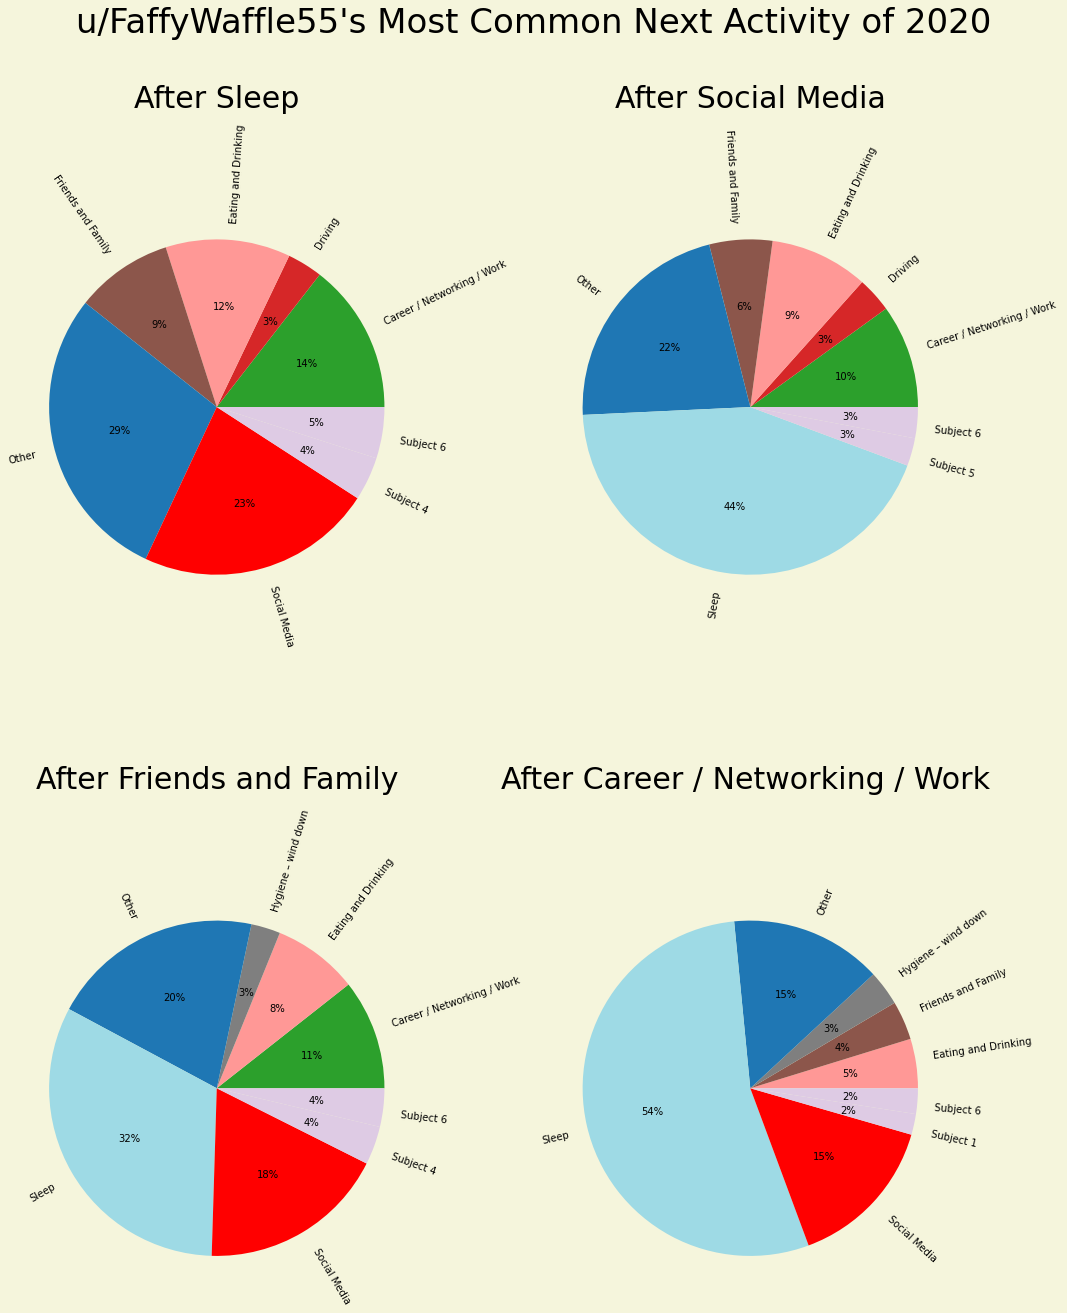

In [19]:
## let's just go with these four for a nice viz
f, axs = plt.subplots(2,2,figsize=(15,20))

# Sleep
plot_pie_after(axs[0,0], "Sleep")

# Social Media
plot_pie_after(axs[0,1], "Social Media")

# Friends and Family
plot_pie_after(axs[1,0], "Friends and Family")

# Career / Networking / Work
plot_pie_after(axs[1,1], "Career / Networking / Work ")


f.suptitle("u/FaffyWaffle55's Most Common Next Activity of 2020", size=34)
f.set_facecolor('beige')
f.tight_layout()
f.savefig("next_activity.png")


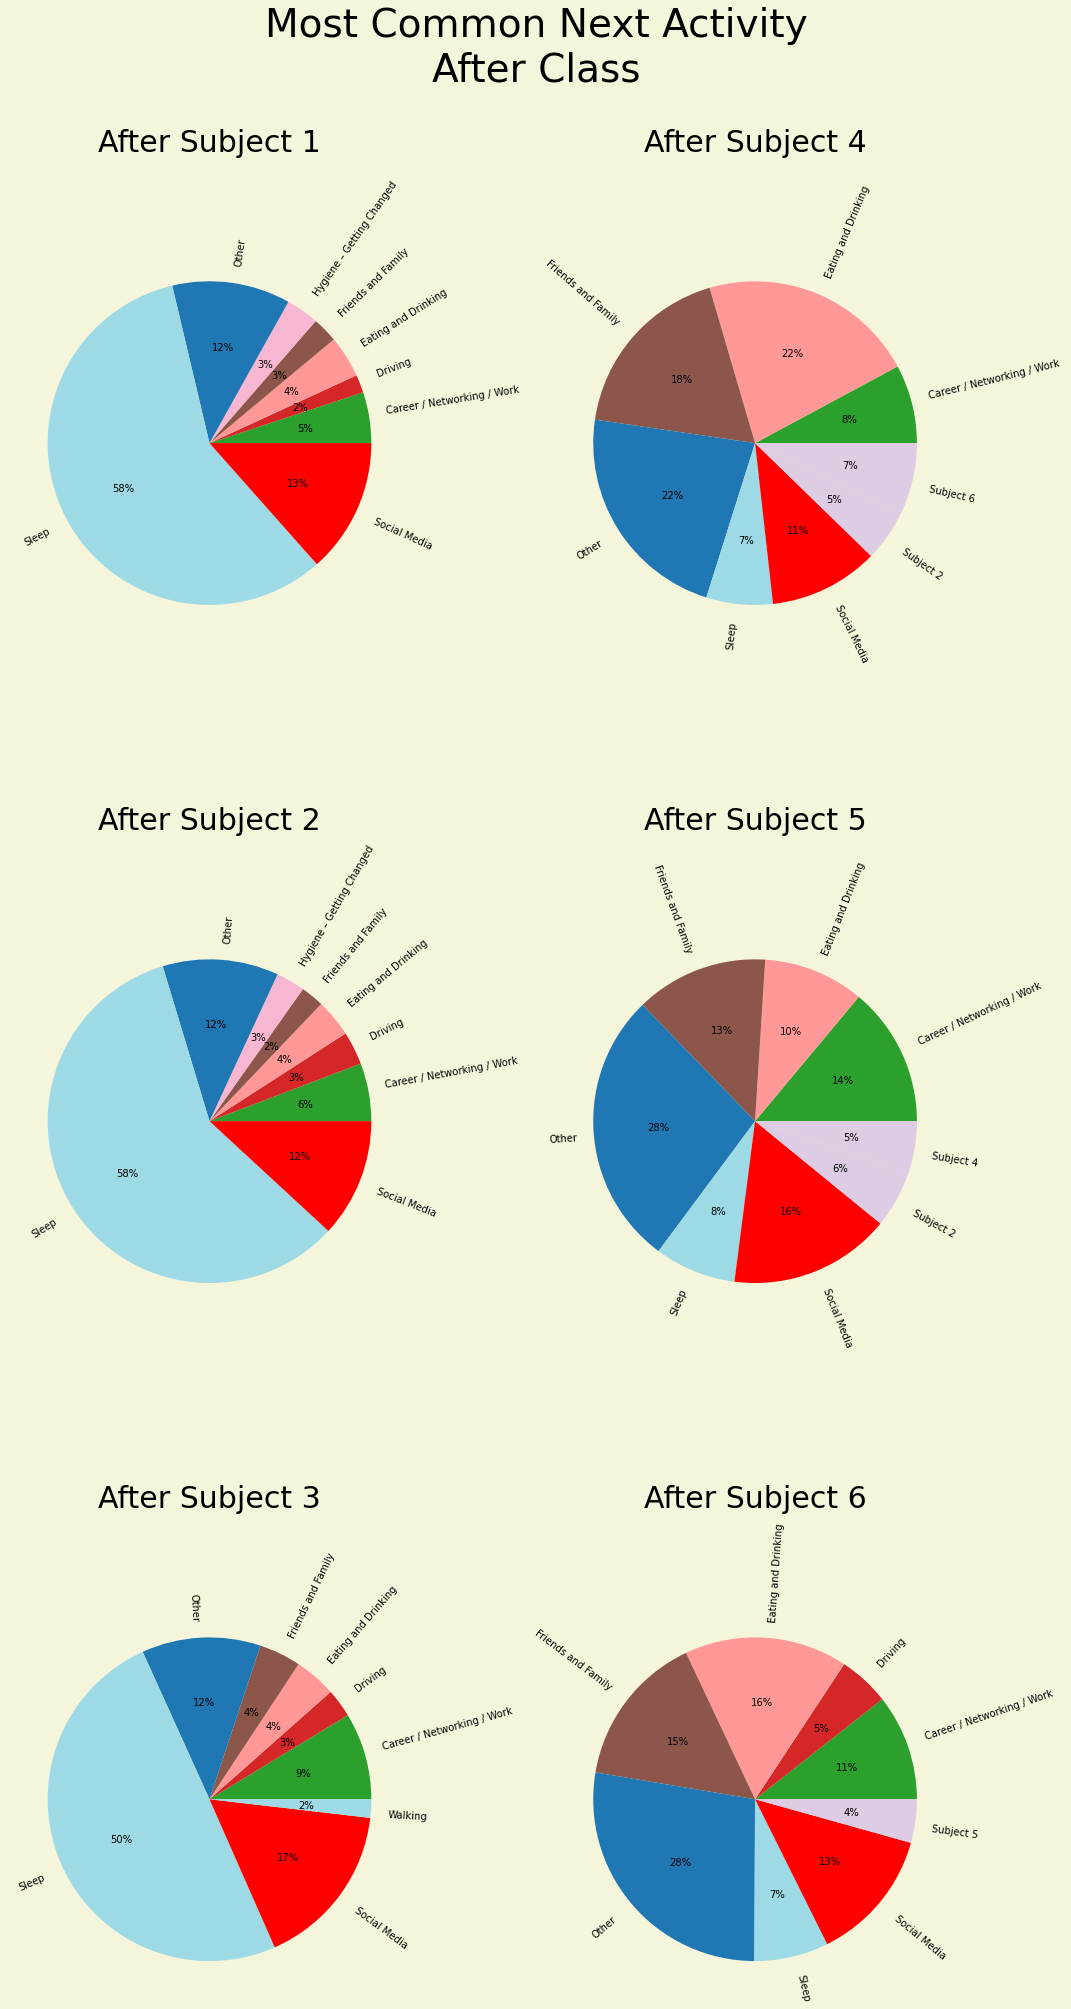

In [20]:
## after study 
f, axs = plt.subplots(3,2,figsize=(15,30))

# Subject 1
plot_pie_after(axs[0,0], "Subject 1")

# Subject 1
plot_pie_after(axs[1,0], "Subject 2")

# Subject 3
plot_pie_after(axs[2,0], "Subject 3")

# Subject 4
plot_pie_after(axs[0,1], "Subject 4")

# Subject 5
plot_pie_after(axs[1,1], "Subject 5")

# Subject 6
plot_pie_after(axs[2,1], "Subject 6")


f.suptitle("Most Common Next Activity\nAfter Class", size=39)
f.set_facecolor('beige')
f.tight_layout()
f.savefig("next_activity_after_class.png")